## Анализ данных по определению стоимости авто

# Важно
1. Качество предсказания
2. Скорость Предсказания
3. Время обучения

# Анализ данных проведем по трем этапам
1. Загрузка и изучение данных, работа с выбросами
2. Подготовка данных и генерация фич при необходимости
3. Выбор ML модели, проверка метрик и определение наиболее влияющих факторов


## 1. Загрузка и изучение данных, работа с выбросами

In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import datetime
import matplotlib as plt
import typing as tp

from collections import Counter
from datetime import datetime
from IPython.display import display

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

!pip install lightgbm
!pip install catboost

from sklearn.linear_model import LinearRegression, Ridge
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

%matplotlib inline

RANDOM_SEED = 47
!pip freeze > requirements.txt

You should consider upgrading via the 'C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [26]:
# Импортируем данные и смотрим на фрейм
autos = pd.read_csv(r'C:\Users\user\Desktop\price_car\autos.csv', encoding = "Latin-1")
display(autos.head(5))
display(autos.info())
display(autos.describe)


,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,odometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-26 17:47:46,Peugeot_807_160_NAVTECH_ON_BOARD,privat,Angebot,"$5,000",control,bus,2004,manuell,158,andere,"150,000km",3,lpg,peugeot,nein,2016-03-26 00:00:00,0,79588,2016-04-06 06:45:54
1,2016-04-04 13:38:56,BMW_740i_4_4_Liter_HAMANN_UMBAU_Mega_Optik,privat,Angebot,"$8,500",control,limousine,1997,automatik,286,7er,"150,000km",6,benzin,bmw,nein,2016-04-04 00:00:00,0,71034,2016-04-06 14:45:08
2,2016-03-26 18:57:24,Volkswagen_Golf_1.6_United,privat,Angebot,"$8,990",test,limousine,2009,manuell,102,golf,"70,000km",7,benzin,volkswagen,nein,2016-03-26 00:00:00,0,35394,2016-04-06 20:15:37
3,2016-03-12 16:58:10,Smart_smart_fortwo_coupe_softouch/F1/Klima/Pan...,privat,Angebot,"$4,350",control,kleinwagen,2007,automatik,71,fortwo,"70,000km",6,benzin,smart,nein,2016-03-12 00:00:00,0,33729,2016-03-15 03:16:28
4,2016-04-01 14:38:50,Ford_Focus_1_6_Benzin_TÜV_neu_ist_sehr_gepfleg...,privat,Angebot,"$1,350",test,kombi,2003,manuell,0,focus,"150,000km",7,benzin,ford,nein,2016-04-01 00:00:00,0,39218,2016-04-01 14:38:50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   dateCrawled          50000 non-null  object
 1   name                 50000 non-null  object
 2   seller               50000 non-null  object
 3   offerType            50000 non-null  object
 4   price                50000 non-null  object
 5   abtest               50000 non-null  object
 6   vehicleType          44905 non-null  object
 7   yearOfRegistration   50000 non-null  int64 
 8   gearbox              47320 non-null  object
 9   powerPS              50000 non-null  int64 
 10  model                47242 non-null  object
 11  odometer             50000 non-null  object
 12  monthOfRegistration  50000 non-null  int64 
 13  fuelType             45518 non-null  object
 14  brand                50000 non-null  object
 15  notRepairedDamage    40171 non-null  object
 16  date

None

<bound method NDFrame.describe of                dateCrawled                                               name  \
0      2016-03-26 17:47:46                   Peugeot_807_160_NAVTECH_ON_BOARD   
1      2016-04-04 13:38:56         BMW_740i_4_4_Liter_HAMANN_UMBAU_Mega_Optik   
2      2016-03-26 18:57:24                         Volkswagen_Golf_1.6_United   
3      2016-03-12 16:58:10  Smart_smart_fortwo_coupe_softouch/F1/Klima/Pan...   
4      2016-04-01 14:38:50  Ford_Focus_1_6_Benzin_TÜV_neu_ist_sehr_gepfleg...   
...                    ...                                                ...   
49995  2016-03-27 14:38:19   Audi_Q5_3.0_TDI_qu._S_tr.__Navi__Panorama__Xenon   
49996  2016-03-28 10:50:25  Opel_Astra_F_Cabrio_Bertone_Edition___TÜV_neu+...   
49997  2016-04-02 14:44:48                     Fiat_500_C_1.2_Dualogic_Lounge   
49998  2016-03-08 19:25:42                 Audi_A3_2.0_TDI_Sportback_Ambition   
49999  2016-03-14 00:42:12                                Opel_Vectra_1.6_1

# Основные фичи 
* dateCrawled - дата скачивания анкеты из базы
* name - модель автомобиля
* seller - продавец частник или дилер
* offerType - типа списка
# price - целевой таргет
* abtest - включение в a/b тест
* vehicleType - тип машины
* yearOfRegistration - год первичной регистрации
* gearbox - тип коробки передач
* powerPS - мощность в л.с.
* model - название модели автомобиля
* kilometer - пробег
* monthOfRegistration - месяц первичной регистрации
* fuelType - тип используемого топлива
* brand - бренд авто
* notRepairedDamage - если есть повреждение для ремонта
* dateCreated - дата создания анкеты на сайте
* nrOfPictures - количество фото авто на сайте
* postalCode - почтовый андекс местонаходжения
* lastSeenOnline - дата последней активности на сайте владельца

1.2 Проверка на Nan и нул

AttributeError: module 'matplotlib' has no attribute 'title'

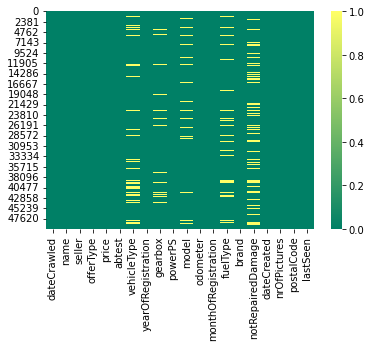

In [27]:
sns.heatmap(autos.isnull(), cmap = 'summer')
plt.title('Диаграмма 1 Пропущенные значения по фичам')

AttributeError: module 'matplotlib' has no attribute 'title'

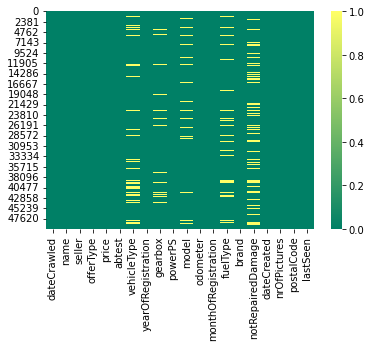

In [ ]:
sns.heatmap(autos.isna(), cmap = 'summer')
plt.title('Диаграмма 1 Пропущенные значения по фичам')

In [32]:
display('количество пропусков', autos.isna().sum())
display('количество нулей', autos.isnull().sum())
display('количество уникальных значений', autos.nunique())

'количество пропусков'

dateCrawled               0
name                      0
seller                    0
offerType                 0
price                     0
abtest                    0
vehicleType            5095
yearOfRegistration        0
gearbox                2680
powerPS                   0
model                  2758
odometer                  0
monthOfRegistration       0
fuelType               4482
brand                     0
notRepairedDamage      9829
dateCreated               0
nrOfPictures              0
postalCode                0
lastSeen                  0
dtype: int64

'количество нулей'

dateCrawled               0
name                      0
seller                    0
offerType                 0
price                     0
abtest                    0
vehicleType            5095
yearOfRegistration        0
gearbox                2680
powerPS                   0
model                  2758
odometer                  0
monthOfRegistration       0
fuelType               4482
brand                     0
notRepairedDamage      9829
dateCreated               0
nrOfPictures              0
postalCode                0
lastSeen                  0
dtype: int64

'количество уникальных значений'

dateCrawled            48213
name                   38754
seller                     2
offerType                  2
price                   2357
abtest                     2
vehicleType                8
yearOfRegistration        97
gearbox                    2
powerPS                  448
model                    245
odometer                  13
monthOfRegistration       13
fuelType                   7
brand                     40
notRepairedDamage          2
dateCreated               76
nrOfPictures               1
postalCode              7014
lastSeen               39481
dtype: int64

Проблемные фичи - тип коробки, тип машины, модель, тип топлива и информации о ремонта, это достаточно важные фичи с т.з. влияния на цену

Все пропущенные значения/нули заполним unknown

In [34]:
change_list = ['notRepairedDamage', 'vehicleType', 'fuelType', 'gearbox']
for col in change_list:
    autos[col].fillna('unknown', inplace=True)

у нас ключая фича и пробег - текст, надо перевести их оцифровать

In [66]:
autos['price_n'] = (autos['price'] # можно как-то через регулярки - надо изучить!!
.str.replace('$','')
.str.replace(',', '')
.astype(int)
)
autos["odometer_n"] = (autos["odometer"]
                     .str.replace("km","")
                     .str.replace(",", "")
                     .astype(int)
                    )
autos['odometer_n'].head(5)

C:\Users\user\AppData\Local\Temp/ipykernel_15704/1496678800.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  autos['price_n'] = (autos['price'] # можно как-то через регулярки - надо изучить!!


0    150000
1    150000
2     70000
3     70000
4    150000
Name: odometer_n, dtype: int32

У нас несколько столбцов с датами, их тоже бы неплохо обработать
* дата скачивания из базы
* дата регистрации авто
* дата создания объявления
* когда последний раз заходил пользователь

In [73]:
autos["yearOfRegistration"].describe()

count    50000.000000
mean      2005.073280
std        105.712813
min       1000.000000
25%       1999.000000
50%       2003.000000
75%       2008.000000
max       9999.000000
Name: yearOfRegistration, dtype: float64

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


AttributeError: module 'matplotlib' has no attribute 'title'

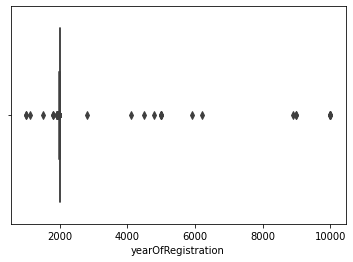

In [74]:
sns.boxplot(autos['yearOfRegistration'])
plt.title('Диаграмма размаха yearOfRegistration')
plt.show()

In [79]:
(~autos["yearOfRegistration"].between(1900,2016)).sum()/autos.shape[0] # можем ли мы избавиться от выбросов?

0.03944

In [80]:
# удалим строки с аномальными значениями годов, так как это 4% от всего датасета
autos = autos[autos['yearOfRegistration'].between(1900,2016)]
autos["yearOfRegistration"].describe()


count    48028.00000
mean      2002.80351
std          7.31085
min       1910.00000
25%       1999.00000
50%       2003.00000
75%       2008.00000
max       2016.00000
Name: yearOfRegistration, dtype: float64

In [81]:
# посмотрим, когда одновременно ли скачались данные, чтобы исключить влияние временного фактора/сезонности
(autos['dateCrawled']
.str[:10]
.value_counts(normalize=True, dropna = False)
.sort_index()
)

2016-03-05    0.025256
2016-03-06    0.014075
2016-03-07    0.036146
2016-03-08    0.033522
2016-03-09    0.033356
2016-03-10    0.032190
2016-03-11    0.032356
2016-03-12    0.036708
2016-03-13    0.015741
2016-03-14    0.036395
2016-03-15    0.034022
2016-03-16    0.029379
2016-03-17    0.031711
2016-03-18    0.012972
2016-03-19    0.034792
2016-03-20    0.037957
2016-03-21    0.037499
2016-03-22    0.032814
2016-03-23    0.032335
2016-03-24    0.029254
2016-03-25    0.031607
2016-03-26    0.032294
2016-03-27    0.030753
2016-03-28    0.034605
2016-03-29    0.034188
2016-03-30    0.033751
2016-03-31    0.031877
2016-04-01    0.033918
2016-04-02    0.035479
2016-04-03    0.038873
2016-04-04    0.036645
2016-04-05    0.012992
2016-04-06    0.003102
2016-04-07    0.001437
Name: dateCrawled, dtype: float64

Видим, что все скачивалось в марте-апреле, что допустимо для оценки авто

In [84]:
# Посмотрим разброс даты по созданию объявления, т.е долго ли висит это объявление
(autos['dateCreated']
		.str[:10]
		.value_counts(normalize=True, dropna=False)
		.sort_index()
		)

2015-06-11    0.000021
2015-08-10    0.000021
2015-09-09    0.000021
2015-11-10    0.000021
2015-12-05    0.000021
                ...   
2016-04-03    0.039102
2016-04-04    0.036978
2016-04-05    0.011785
2016-04-06    0.003186
2016-04-07    0.001291
Name: dateCreated, Length: 74, dtype: float64

Самые старые - почти 9 месяцев, значит никто не берет авто, это важная фича!

# Проверим количественные фичи powerPS, odometer_n  и таргет на выбросы/аномалии 

In [98]:
autos.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,...,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen,price_n,odometer_n
0,2016-03-26 17:47:46,Peugeot_807_160_NAVTECH_ON_BOARD,privat,Angebot,"$5,000",control,bus,2004,manuell,158,...,3,lpg,peugeot,nein,2016-03-26 00:00:00,0,79588,2016-04-06 06:45:54,5000,150000
1,2016-04-04 13:38:56,BMW_740i_4_4_Liter_HAMANN_UMBAU_Mega_Optik,privat,Angebot,"$8,500",control,limousine,1997,automatik,286,...,6,benzin,bmw,nein,2016-04-04 00:00:00,0,71034,2016-04-06 14:45:08,8500,150000
2,2016-03-26 18:57:24,Volkswagen_Golf_1.6_United,privat,Angebot,"$8,990",test,limousine,2009,manuell,102,...,7,benzin,volkswagen,nein,2016-03-26 00:00:00,0,35394,2016-04-06 20:15:37,8990,70000
3,2016-03-12 16:58:10,Smart_smart_fortwo_coupe_softouch/F1/Klima/Pan...,privat,Angebot,"$4,350",control,kleinwagen,2007,automatik,71,...,6,benzin,smart,nein,2016-03-12 00:00:00,0,33729,2016-03-15 03:16:28,4350,70000
4,2016-04-01 14:38:50,Ford_Focus_1_6_Benzin_TÜV_neu_ist_sehr_gepfleg...,privat,Angebot,"$1,350",test,kombi,2003,manuell,0,...,7,benzin,ford,nein,2016-04-01 00:00:00,0,39218,2016-04-01 14:38:50,1350,150000
